<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/graph-based-topology/undirected_weighted_connected_graph_avg_min_max_consensus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [337]:
!pip install igraph

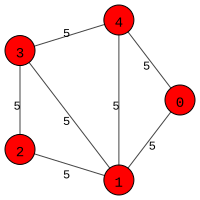

In [338]:
import igraph as ig
import numpy as np
import matplotlib as plt
# Create the graph
g = ig.Graph(directed=False)
N = 5
g.add_vertices(N)
g.add_edges([(0, 1), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (3, 4)])
# g.add_edges([(0, 1), (1, 2), (0, 2)])
# g.es['weight'] = [1000, 1000, 1]
g.es['weight'] = [5, 5, 5, 5, 5, 5, 5]
# normalize weights
# g.es['weight'] = g.es['weight'] / np.sum(g.es['weight'])
# g.es['weight'] = [1,1,1,1,1,1,1]

# Optional: add vertex labels (e.g., numbers or names)
g.vs['label'] = [str(v.index) for v in g.vs]  # labels as string indices

# Also show edge weights as labels
g.es['label'] = g.es['weight']

# Layout and plot
layout = g.layout('circle')  # Kamada-Kawai layout
ig.plot(
    g,
    layout=layout,
    bbox=(200, 200),
    vertex_size=30,
    vertex_label=g.vs['label'],
    edge_label=g.es['label']
)


In [339]:
edge_weights = {}
for edge in g.es:
    edge_weights[(edge.source, edge.target)] = edge['weight']
    edge_weights[(edge.target, edge.source)] = edge['weight']

print(edge_weights)

{(0, 1): 5, (1, 0): 5, (0, 4): 5, (4, 0): 5, (1, 2): 5, (2, 1): 5, (1, 3): 5, (3, 1): 5, (1, 4): 5, (4, 1): 5, (2, 3): 5, (3, 2): 5, (3, 4): 5, (4, 3): 5}


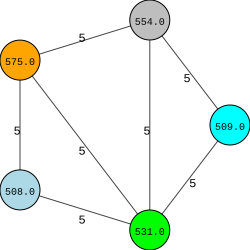

In [340]:
# init 5 random values for the edges between 500, 1000
x_values = np.array(np.random.randint(500, 600, size=N), dtype=float)
# x_values = [10,1,10]

# Assign edge colors and labels
colors = ["cyan", "green", "lightblue", "orange", "gray"]
g.vs["color"] = colors
g.vs['label'] = [str(v) for v in x_values]

ig.plot(
    g,
    layout=layout,
    bbox=(250, 250),
    vertex_size=40,
    vertex_label_size=10,
    edge_label=g.es['label']
)

In [341]:
# Get weighted adjacency matrix
A = np.array(g.get_adjacency(attribute='weight').data, dtype=float)

print("Weighted Adjacency Matrix:")
print(A)

def sinkhorn_knopp(A, max_iter=1000, tol=1e-6):
    A = A.copy()
    for _ in range(max_iter):
        A /= A.sum(axis=1, keepdims=True)  # Row normalize
        A /= A.sum(axis=0, keepdims=True)  # Column normalize
        if np.allclose(A.sum(axis=0), 1, atol=tol) and np.allclose(A.sum(axis=1), 1, atol=tol):
            break
    return A


# # make A doubly schocastic
# A = sinkhorn_knopp(A)

# print("Schocastic Weighted Adjacency Matrix:")
# print(A)

A = A/A.sum(axis=1, keepdims=True)  # Row normalize

A_power = np.linalg.matrix_power(A, 10000)

print("A^2:")
print(A)

final_vals_matrix_power = np.dot(A_power, x_values)
final_vals = A_power @ x_values
print("Consensus values:", final_vals)
print("Deviation from average:", np.abs(final_vals - final_vals.mean()))


Weighted Adjacency Matrix:
[[0. 5. 0. 0. 5.]
 [5. 0. 5. 5. 5.]
 [0. 5. 0. 5. 0.]
 [0. 5. 5. 0. 5.]
 [5. 5. 0. 5. 0.]]
A^2:
[[0.         0.5        0.         0.         0.5       ]
 [0.25       0.         0.25       0.25       0.25      ]
 [0.         0.5        0.         0.5        0.        ]
 [0.         0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.33333333 0.         0.33333333 0.        ]]
Consensus values: [538.92857143 538.92857143 538.92857143 538.92857143 538.92857143]
Deviation from average: [0. 0. 0. 0. 0.]


In [342]:
print (x_values, f"median = {np.median(x_values)} avg = {np.average(x_values)}")

[509. 531. 508. 575. 554.] median = 531.0 avg = 535.4


Converged after 7701 iterations.


/tmp/ipython-input-343-896347281.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'Nodes (T = {len(history)} iterations)')


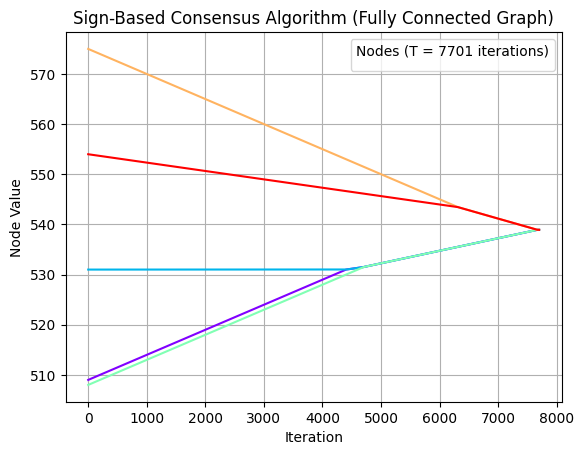

[538.93       538.93       538.925      538.93       538.92666667]
is matrix power method close to sign consensus ?  False


In [343]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt

N = len(x_values)
x_init = x_values
orig = x_init.copy()

epsilon = 0.001

# History to visualize evolution
history = [x_init.copy()]
are_within_tolerance = False
iter = 0
max_iters = 500000
neighbors_list = [g.neighbors(i) for i in range(g.vcount())]

while(are_within_tolerance == False):
    iter += 1
    x_prev = x_init.copy()  # snapshot for synchronous update
    x_new = x_prev.copy()

    for v in g.vs:
        i = v.index
        sign_sum = np.sum([edge_weights.get((i,j), edge_weights.get((j,i), 0)) * np.sign(x_prev[i] - x_prev[j]) for j in neighbors_list[i]])
        x_new[i] = x_prev[i] - (epsilon / len(neighbors_list[i])) * sign_sum

    x_init = x_new

    history.append(x_init.copy())

    if iter % 100 == 0:
      # check if all elements in the array are 1e-3 tol to each otherr
      reference_value = history[-1][0]
      are_within_tolerance = np.allclose(history[-1], reference_value, atol=1e-3)

      # check if the standard dev of last 10 history array values is < tol
      if iter > max_iters:
        are_within_tolerance = True

      # print (f"Iteration {iter}: {history[-1]}")
      if are_within_tolerance:
        print(f"Converged after {iter + 1} iterations.")
        break

# Plot each value of x in history
history = np.array(history)
final_value_sign_based = history[-1]
# find N colors
colors =  plt.cm.rainbow(np.linspace(0, 1, N))

for i in range(N):
    plt.plot(history[:, i], color=colors[i])

plt.xlabel('Iteration')
plt.ylabel('Node Value')
plt.title('Sign-Based Consensus Algorithm (Fully Connected Graph)')
plt.legend(title=f'Nodes (T = {len(history)} iterations)')
plt.grid(True)

plt.show()
print(history[-1])
print('is matrix power method close to sign consensus ? ', np.all(np.isclose(history[-1], np.dot(A, orig), atol=1e-1)))


Converged after 2201 iterations.


/tmp/ipython-input-344-3730299095.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'Nodes (T = {len(history)} iterations)')


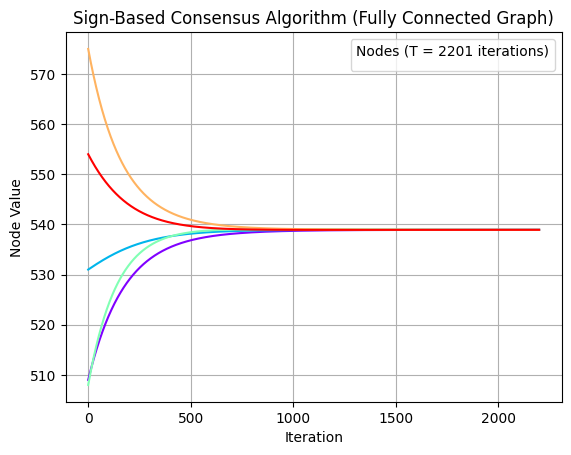

[538.926635   538.92852283 538.93040776 538.92967224 538.92760215]
is matrix power method close to sign consensus ?  False


In [344]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt

N = len(x_values)
x_init = x_values
orig = x_init.copy()

epsilon = 0.001

# History to visualize evolution
history = [x_init.copy()]
are_within_tolerance = False
iter = 0
max_iters = 500000
neighbors_list = [g.neighbors(i) for i in range(g.vcount())]

while(are_within_tolerance == False):
    iter += 1
    x_prev = x_init.copy()  # snapshot for synchronous update
    x_new = x_prev.copy()

    for v in g.vs:
        i = v.index
        sign_sum = np.sum([edge_weights.get((i,j), edge_weights.get((j,i), 0)) * (x_prev[j] - x_prev[i]) for j in neighbors_list[i]])
        x_new[i] = x_prev[i] + (epsilon / len(neighbors_list[i])) * sign_sum

    x_init = x_new

    history.append(x_init.copy())

    if iter % 100 == 0:
      # check if all elements in the array are 1e-3 tol to each otherr
      reference_value = history[-1][0]
      are_within_tolerance = np.allclose(history[-1], reference_value, atol=1e-5)

      # check if the standard dev of last 10 history array values is < tol
      if iter > max_iters:
        are_within_tolerance = True

      # print (f"Iteration {iter}: {history[-1]}")
      if are_within_tolerance:
        print(f"Converged after {iter + 1} iterations.")
        break

# Plot each value of x in history
history = np.array(history)
final_value_avg_based = history[-1]

# find N colors
colors =  plt.cm.rainbow(np.linspace(0, 1, N))

for i in range(N):
    plt.plot(history[:, i], color=colors[i])

plt.xlabel('Iteration')
plt.ylabel('Node Value')
plt.title('Sign-Based Consensus Algorithm (Fully Connected Graph)')
plt.legend(title=f'Nodes (T = {len(history)} iterations)')
plt.grid(True)

plt.show()
print(history[-1])
print('is matrix power method close to sign consensus ? ', np.all(np.isclose(history[-1], np.dot(A, orig), atol=1e-1)))


In [345]:
final_vals_matrix_power, final_value_avg_based, final_value_sign_based, np.median(x_values), np.average(x_values)


(array([538.92857143, 538.92857143, 538.92857143, 538.92857143,
        538.92857143]),
 array([538.926635  , 538.92852283, 538.93040776, 538.92967224,
        538.92760215]),
 array([538.93      , 538.93      , 538.925     , 538.93      ,
        538.92666667]),
 np.float64(531.0),
 np.float64(535.4))